In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchviz import make_dot
from torch.utils.tensorboard import SummaryWriter
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import os
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

from typing import Dict, Tuple
from tqdm import tqdm
from IPython.display import HTML

In [2]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels : int, out_channels : int, is_res : bool = False):
        super().__init__()
        self.same_channels = in_channels == out_channels
        self.is_res = is_res

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

        if not self.same_channels:
            self.shortcut = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)
        else:
            self.shortcut = None

    def forward(self, x : torch.Tensor):
        if self.is_res:
            out = self.conv1(x)
            out = self.conv2(out)
            if self.same_channels:
                out += x
            else:
                # shortcut = nn.Conv2d(x[1], out[1], kernel_size=1, stride=1, padding=0).to(x.device)
                out += self.shortcut(x)
            return out / 1.414
        else:
            out = self.conv1(x)
            out = self.conv2(out)
            return out

In [3]:
class UnetUp(nn.Module):
    def __init__(self, in_channels : int, out_channels : int):
        super(UnetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels)
        ]
        self.model = nn.Sequential(*layers)
    
    def forward(self, x, skip):
        out = torch.cat((x, skip), 1)
        out = self.model(out)
        return out

In [4]:
class UnetDown(nn.Module):
    def __init__(self, in_channels : int, out_channels : int):
        super(UnetDown, self).__init__()
        layers = [
            ResidualConvBlock(in_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
            nn.MaxPool2d(2)
        ]
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [5]:
class EmbedFC(nn.Module):
    def __init__(self, input_dim : int, embed_dim : int):
        super(EmbedFC, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, embed_dim),
            nn.GELU(),
            nn.Linear(embed_dim, embed_dim)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        out = x.view(-1, self.input_dim)
        return self.model(out)

In [6]:
def unorm(x):
    xmax = x.max((0,1))
    xmin = x.min((0,1))
    return (x - xmin) / (xmax - xmin)

In [7]:
def norm_all(store, n_t, n_s):
    nstore = np.zeros_like(store)
    for t in range(n_t):
        for s in range(n_s):
            nstore[t, s] = unorm(store[t, s])
    return nstore

In [8]:
def norm_torch(x_all):
    x = x_all.cpu().numpy()
    xmax = x.max((2, 3))
    xmin = x.min((2, 3))
    xmax = np.expand_dims(xmax, (2, 3))
    xmin = np.expand_dims(xmin, (2, 3))
    nstore = (x - xmin) / (xmax - xmin)
    return torch.from_numpy(nstore)

In [9]:
def gen_tst_context(n_cfeat):
    vec = torch.tensor([
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0],
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0],
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0],
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0],
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0],
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0]]
    )
    return len(vec), vec

In [10]:
def plot_grid(x, n_samples, n_rows, save_dir, w):
    n_cols = n_samples // n_rows
    grid = make_grid(norm_torch(x), nrow=n_rows)
    save_image(grid, save_dir + f"run_image_w{w}.png")
    print('saved image at ' + save_dir + f"run_image_w{w}.png")
    return grid

In [11]:
def plot_sample(x_gen_store, n_sample, nrows, save_dir, fn, w, save=False):
    ncols = n_sample // nrows
    sx_gen_store = np.moveaxis(x_gen_store, 2, 4)
    nsx_gen_store = norm_all(sx_gen_store, sx_gen_store.shape[0], n_sample)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(nrows, ncols))

    def animate_diff(i, store):
        print(f'gif animating frame {i} of {store.shape[0]}', end='\r')
        plots = []
        for row in range(nrows):
            for col in range(ncols):
                axs[row, col].clear()
                axs[row, col].set_xticks([])
                axs[row, col].set_yticks([])
                plots.append(axs[row, col].imshow(store[i, (row * ncols) + col]))
        return plots
    
    ani = FuncAnimation(fig, animate_diff, fargs=[nsx_gen_store], interval=200, blit=False, repeat=True, frames=nsx_gen_store.shape[0])
    plt.close()

    if save:
        ani.save(save_dir + f"{fn}_w{w}.gif", dpi=100, writer=PillowWriter(fps=5))
        print('saved gif at ' + save_dir + f"{fn}_w{w}.gif")
    return ani

In [12]:
class CustomDataset(Dataset):
    def __init__(self, sfilename, lfilename, transform, null_context = False):
        self.sprites = np.load(sfilename)
        self.slabels = np.load(lfilename)
        print(f"sprite shape: {self.sprites.shape}")
        print(f"labels shape: {self.slabels.shape}")
        self.transform = transform
        self.null_context = null_context
        self.sprite_shape = self.sprites.shape
        self.slabel_shape = self.slabels.shape
    
    def __len__(self):
        return len(self.sprites)
    
    def __getitem__(self, index):
        if self.transform:
            image = self.transform(self.sprites[index])
            if self.null_context:
                label = torch.tensor(0).to(torch.int64)
            else:
                label = torch.tensor(self.slabels[index]).to(torch.int64)
        return (image, label)
    
    def getshapes(self):
        return self.sprite_shape, self.slabel_shape
    
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [13]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels : int, n_feat : int=256, n_cfeat : int=10, height : int=28):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.h = height

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d((4)), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2 * n_feat)
        self.timeembed2 = EmbedFC(1, n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 2 * n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, n_feat)

        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, height//4, height//4),
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU()
        )
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)

        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, in_channels, 3, 1, 1)
        )

    def forward(self, x, t, c=None):
        x = self.init_conv(x)

        down1 = self.down1(x)
        down2 = self.down2(down1)

        hiddenvec = self.to_vec(down2)

        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)

        temb1 = self.timeembed1(t).view(-1, 2 * self.n_feat, 1, 1)
        cemb1 = self.contextembed1(c).view(-1, 2 * self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)

        up0 = self.up0(hiddenvec)
        up1 = self.up1(cemb1 * up0 + temb1, down2)
        up2 = self.up2(cemb2 * up1 + temb2, down1)
        out = self.out(torch.cat((up2, x), 1))
        return out

In [14]:
timesteps = 500
beta1 = 1e-4
beta2 = 0.02

device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64
n_cfeat = 5
height = 16
save_dir = './weights/'

batch_size = 100
n_epoch = 32
lrate = 1e-3

In [15]:
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
# print('b_t : ', b_t)
a_t = 1 - b_t
# print('a_t : ', a_t)
# print('a_t.log() : ', a_t.log())
# print('torch.cumsum(a_t.log(), dim=0) : ', torch.cumsum(a_t.log(), dim=0))
# print('torch.cumsum(a_t.log(), dim=0).exp() : ', torch.cumsum(a_t.log(), dim=0).exp())
ab_t = torch.cumsum(a_t.log(), dim=0).exp()
ab_t[0] = 1
# print('ab_t : ', ab_t)

In [16]:
nn_model = ContextUnet(3, n_feat, n_cfeat, height).to(device)

In [39]:
# x = torch.randn(batch_size, 3, height, height).to(device)
# t = torch.randn(batch_size, 1).to(device)
# c = torch.randn(batch_size, n_cfeat).to(device)

# output = nn_model(x, t, c)

# make_dot(output, params=dict(nn_model.named_parameters())).render("context_unet", format="png")

In [40]:
# writer = SummaryWriter('runs/context_unet_experiment')

# x = torch.randn(batch_size, 3, height, height).to(device)
# t = torch.randn(batch_size, 1).to(device)
# c = torch.randn(batch_size, n_cfeat).to(device)

# writer.add_graph(nn_model, (x, t, c))
# writer.close()

In [17]:
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

In [18]:
dataset = CustomDataset('./sprites_1788_16x16.npy','./sprite_labels_nc_1788_16x16.npy', transform, null_context=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)

sprite shape: (89400, 16, 16, 3)
labels shape: (89400, 5)


In [19]:
def perturb_input(x, t, noise):
    return ab_t.sqrt()[t, None, None, None] * x + (1 - ab_t[t, None, None, None]) * noise

In [44]:
nn_model.train()

for ep in range(n_epoch):
    print (f'Epoch {ep}')

    optim.param_groups[0]['lr'] = lrate * (1-ep/n_epoch)

    pbar = tqdm(dataloader, mininterval=2)
    for x, c in pbar:
        optim.zero_grad()

        x = x.to(device)
        c = c.to(x)

        context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.9).to(device)
        c = c * context_mask.unsqueeze(-1)

        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps + 1, (x.shape[0],)).to(device)
        x_pert = perturb_input(x, t, noise)

        pred_noise = nn_model(x_pert, t/timesteps, c=c)

        loss = F.mse_loss(pred_noise, noise)
        loss.backward()

        optim.step()

    if ep%4==0 or ep==(n_epoch-1):
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        torch.save(nn_model.state_dict(), save_dir + f"context_model_{ep}.pth")
        print('saved model at ' + save_dir + f"context_model_{ep}.pth")

Epoch 0


100%|██████████| 894/894 [06:38<00:00,  2.24it/s]


saved model at ./weights/context_model_0.pth
Epoch 1


100%|██████████| 894/894 [06:40<00:00,  2.23it/s]


Epoch 2


100%|██████████| 894/894 [07:54<00:00,  1.88it/s]


Epoch 3


100%|██████████| 894/894 [05:10<00:00,  2.88it/s]


Epoch 4


100%|██████████| 894/894 [05:13<00:00,  2.85it/s]


saved model at ./weights/context_model_4.pth
Epoch 5


100%|██████████| 894/894 [05:22<00:00,  2.77it/s]


Epoch 6


100%|██████████| 894/894 [06:32<00:00,  2.28it/s]


Epoch 7


100%|██████████| 894/894 [06:34<00:00,  2.27it/s]


Epoch 8


100%|██████████| 894/894 [06:32<00:00,  2.28it/s]


saved model at ./weights/context_model_8.pth
Epoch 9


100%|██████████| 894/894 [06:28<00:00,  2.30it/s]


Epoch 10


100%|██████████| 894/894 [06:31<00:00,  2.28it/s]


Epoch 11


100%|██████████| 894/894 [06:32<00:00,  2.28it/s]


Epoch 12


100%|██████████| 894/894 [06:23<00:00,  2.33it/s]


saved model at ./weights/context_model_12.pth
Epoch 13


100%|██████████| 894/894 [05:51<00:00,  2.55it/s]


Epoch 14


100%|██████████| 894/894 [06:34<00:00,  2.27it/s]


Epoch 15


100%|██████████| 894/894 [06:35<00:00,  2.26it/s]


Epoch 16


100%|██████████| 894/894 [06:33<00:00,  2.27it/s]


saved model at ./weights/context_model_16.pth
Epoch 17


100%|██████████| 894/894 [06:46<00:00,  2.20it/s]


Epoch 18


100%|██████████| 894/894 [07:10<00:00,  2.07it/s]


Epoch 19


100%|██████████| 894/894 [06:09<00:00,  2.42it/s]


Epoch 20


100%|██████████| 894/894 [05:19<00:00,  2.80it/s]


saved model at ./weights/context_model_20.pth
Epoch 21


100%|██████████| 894/894 [06:02<00:00,  2.47it/s]


Epoch 22


100%|██████████| 894/894 [06:25<00:00,  2.32it/s]


Epoch 23


100%|██████████| 894/894 [07:43<00:00,  1.93it/s]


Epoch 24


100%|██████████| 894/894 [07:22<00:00,  2.02it/s]


saved model at ./weights/context_model_24.pth
Epoch 25


100%|██████████| 894/894 [07:03<00:00,  2.11it/s]


Epoch 26


100%|██████████| 894/894 [06:32<00:00,  2.28it/s]


Epoch 27


100%|██████████| 894/894 [06:05<00:00,  2.45it/s]


Epoch 28


100%|██████████| 894/894 [05:53<00:00,  2.53it/s]


saved model at ./weights/context_model_28.pth
Epoch 29


100%|██████████| 894/894 [05:49<00:00,  2.56it/s]


Epoch 30


100%|██████████| 894/894 [05:50<00:00,  2.55it/s]


Epoch 31


100%|██████████| 894/894 [05:50<00:00,  2.55it/s]

saved model at ./weights/context_model_31.pth


In [21]:
nn_model.load_state_dict(torch.load(f"{save_dir}context_model_31.pth", map_location=device))
nn_model.eval() 
print("Loaded in Context Model")

Loaded in Context Model


In [22]:
def denoise_add_noise(x, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)

    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise

In [23]:
@torch.no_grad()
def sample_ddpm_context(n_sample, context, save_rate=20):
    samples = torch.randn(n_sample, 3, height, height).to(device)

    intermediate = []
    for i in range(timesteps, 0, -1):
        print(f'sampling timestep {i:3d}', end='\r')

        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)
        z = torch.randn_like(samples) if i > 1 else  0

        eps = nn_model(samples, t, c=context)
        samples = denoise_add_noise(samples, i, eps, z)
        if i % save_rate==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())
    
    intermediate = np.stack(intermediate)
    return samples, intermediate

In [68]:
plt.clf()
ctx = F.one_hot(torch.randint(0, 5, (32,)), 5).to(device=device).float()
samples, intermediate = sample_ddpm_context(32, ctx)
animation_ddpm_context = plot_sample(intermediate, 32, 4, save_dir, "ani_run", None)
HTML(animation_ddpm_context.to_jshtml())

<Figure size 640x480 with 0 Axes>

In [24]:
def show_images(imgs, nrow=2):
    _, axs = plt.subplots(nrow, imgs.shape[0] // nrow, figsize=(6, 4))
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        img = (img.permute(1, 2, 0).clip(-1, 1).detach().cpu().numpy() + 1) / 2
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img)
    plt.show()

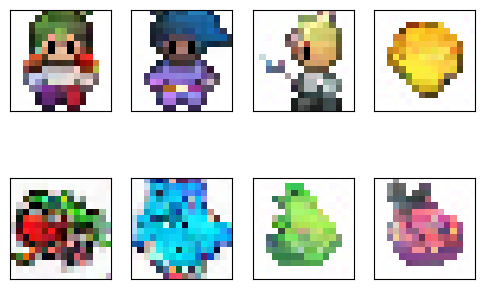

In [28]:
ctx = torch.tensor([
    [1,0,0,0,0],  
    [1,0,0,0,0],    
    [0,0,0,0,1],
    [0,0,1,1,0],    
    [0,1,0,0,0],
    [0,1,0,0,0],
    [0,0,1,0,0],
    [0,0,1,0,0],
]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

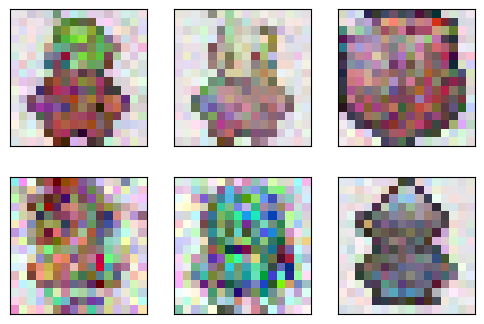

In [75]:
ctx = torch.tensor([
    [1,0,0,0,0],
    [1,0,0.6,0,0],    
    [0,0,0.6,0.4,0],  
    [1,0,0,0,1],  
    [1,1,0,0,0],
    [1,0,0,1,0]
]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)